# Проект для "Викишоп" с BERT

Заказчику — интернет-магазину **«Викишоп»** — необходим инструмент для автоматической модерации пользовательских правок и комментариев. Задача: находить токсичные комментарии и отправлять их на проверку.  

В рамках проекта мы:  
- обучим модель классифицировать комментарии на позитивные и негативные;  
- используем предобученную нейросеть **BERT** для построения эмбеддингов текста;  
- проверим качество модели с помощью метрики **F1** и добьёмся значения не ниже **0.75**;  
- сравним результат с альтернативными классическими методами (Logistic Regression, Random Forest и др.).  

Итогом станет готовое решение, позволяющее заказчику автоматически отсеивать токсичный контент и повышать качество пользовательского взаимодействия с сервисом.  


## Оглавление<a id="1"></a>

1. [Оглавление](#1)
2. [Импорт библиотек](#2)
3. [Заведение функций](#3)
4. [Загрузка и изучение данных](#4)
5. [Работа с моделью BERT](#5)
6. [Итоговый вывод](#6)

## Импорт библиотек<a id="2"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
pip install -q transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxic-comments-csv/toxic_comments.csv


In [5]:
import gc
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Заведение функций<a id="3"></a>

In [6]:
#Функция для очистки текста
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^A-Za-zА-Яа-я0-9!?., ]+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

In [7]:
# Функция для получения эмбеддинга [CLS] одного текста
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    outputs = model(**inputs)
    # Берём скрытое состояние первого токена ([CLS]) из последнего слоя
    cls_vector = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_vector

In [8]:
# Считаем эмбединги с tqdm
def get_embeddings(texts, batch_size=16, max_len=128):
    all_emb = []
    for i in tqdm(range(0, len(texts), batch_size), desc="BERT → эмбеддинги"):
        batch = texts[i:i+batch_size].tolist()
        inputs = tokenizer(batch, return_tensors='pt',
                           truncation=True, padding=True, max_length=max_len).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pooled = mean_pooling(outputs.last_hidden_state, inputs['attention_mask'])
        all_emb.append(pooled.cpu().numpy())

        del inputs, outputs, pooled
        if device.type == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

    emb = np.vstack(all_emb)
    return normalize(emb, norm="l2")

In [9]:

def mean_pooling(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(1)
    denom = torch.clamp(mask.sum(1), min=1e-9)
    return summed / denom

## Загрузка и изучение данных<a id="4"></a>

In [10]:
try:
    df = pd.read_csv('/kaggle/input/toxic-comments-csv/toxic_comments.csv')
except:
    try:
        df = pd.read_csv('toxic_comments.csv')
    except:
        df = pd.read_csv('/datasets/toxic_comments.csv')
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

Проведу очистку от артифактов парсинга при помощи регулярных выражений

In [11]:
df['text_clean'] = df['text'].astype(str).apply(clean_text)
df.sample(5)

,text,toxic,text_clean
62078,attention \n\nSmackBot\n\n please refer t...,0,attention smackbot please refer to othe...
139760,There are so many articles that wish to down p...,0,there are so many articles that wish to down p...
131096,"For the record, since you can't seem to stop p...",0,"for the record, since you can t seem to stop p..."
155542,"""Interested party comment. Firstly Justin is n...",0,interested party comment. firstly justin is no...
34913,REDIRECT Talk:Robert Weaver (surfer),0,redirect talk robert weaver surfer


Немного изучим датасет с которым будем работать

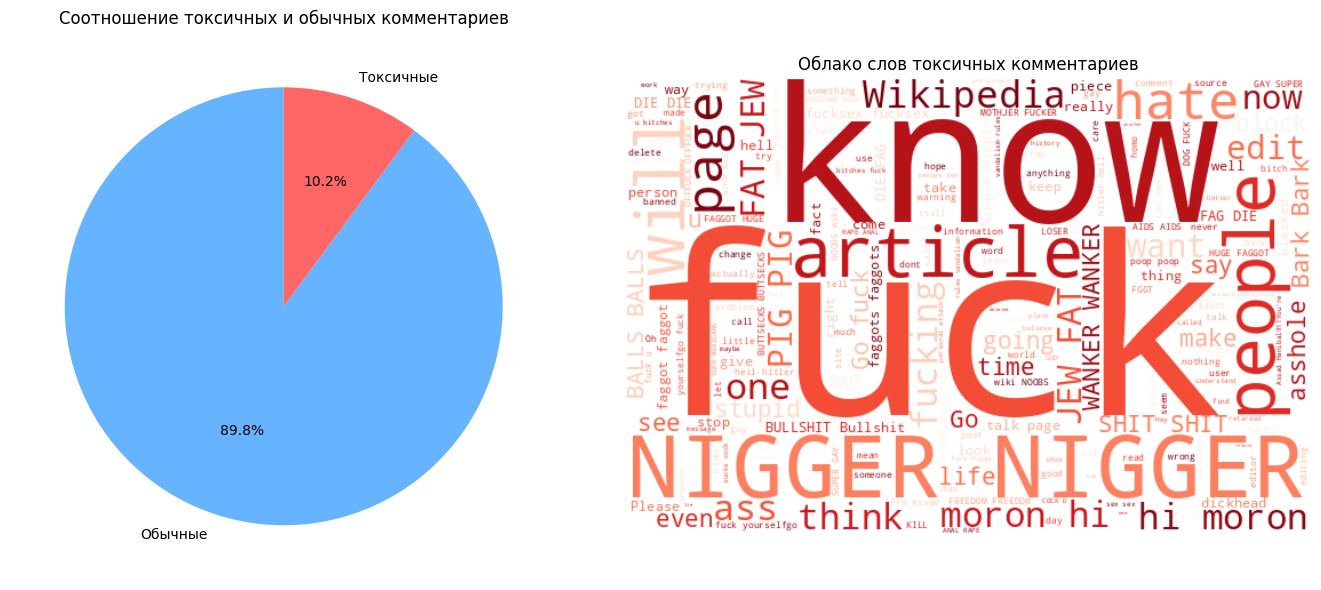

In [12]:
toxic_counts = df['toxic'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].pie(
    toxic_counts,
    labels=['Обычные', 'Токсичные'],
    autopct='%1.1f%%',
    colors=['#66b3ff', '#ff6666'],
    startangle=90
)
axes[0].set_title("Соотношение токсичных и обычных комментариев")
toxic_text = " ".join(df.loc[df['toxic'] == 1, 'text'].astype(str))
wordcloud = WordCloud(
    width=600,
    height=400,
    background_color="white",
    colormap="Reds"
).generate(toxic_text)

axes[1].imshow(wordcloud, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Облако слов токсичных комментариев")
plt.tight_layout()
plt.show()

* **Токсичность**: \~10% комментариев → каждый десятый требует модерации.
* **Частые слова**: преобладают ругательства (*fuck, shit*), оскорбления (*moron, stupid*), этнические/религиозные нападки (*jew, nigger*).
* **Контекст**: встречаются слова про *Wikipedia/page/edit* → данные, вероятно, с Википедии.
* **Вывод**: модель должна улавливать не только мат, но и персональные/этнические оскорбления.

## Работа с моделью<a id="5"></a>

In [13]:
X = df["text_clean"].astype(str)
y = df["toxic"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Размер обучающей выборки: {len(X_train)}, тестовой: {len(X_test)}")
print(f"Доля токсичных в обучающей: {y_train.mean():.2%}, в тестовой: {y_test.mean():.2%}")

Размер обучающей выборки: 127433, тестовой: 31859
Доля токсичных в обучающей: 10.16%, в тестовой: 10.16%


In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

X_train_emb = get_embeddings(X_train, batch_size=16, max_len=128)
X_test_emb  = get_embeddings(X_test,  batch_size=16, max_len=128)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_emb, y_train, test_size=0.15, stratify=y_train, random_state=42
)

scaler = StandardScaler(with_mean=True, with_std=True)
X_tr_s = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test_emb)

clf = LogisticRegression(max_iter=2000, class_weight="balanced",
                         solver="liblinear", C=2.0, random_state=42)
clf.fit(X_tr_s, y_tr)

val_scores = clf.decision_function(X_val_s)

best_f1, best_th = -1, 0
for th in np.linspace(-2, 2, 401):
    preds = (val_scores >= th).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_th = f1, th

print(f"Лучший порог: {best_th:.3f}, F1 на валидации={best_f1:.3f}")

test_scores = clf.decision_function(X_test_s)
y_pred = (test_scores >= best_th).astype(int)
f1_final = f1_score(y_test, y_pred)
print(f"F1 на тесте: {f1_final:.3f}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-09-17 07:49:08.849115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758095349.036516      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758095349.091598      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT → эмбеддинги: 100%|██████████| 1992/1992 [16:11<00:00,  2.05it/s]


Лучший порог: 1.540, F1 на валидации=0.740
F1 на тесте: 0.757


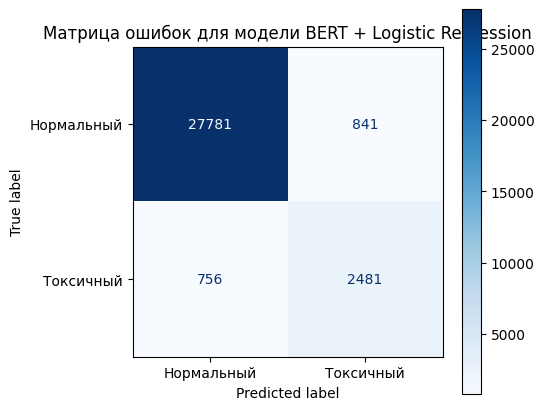

In [15]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Нормальный", "Токсичный"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Матрица ошибок для модели BERT + Logistic Regression")
plt.show()

По матрице ошибок видно:

* **27781** нетоксичных комментариев классифицированы верно.
* **2481** токсичных также определены правильно.
* Ошибки: **756** токсичных не распознаны (FN) и **841** нейтральных ошибочно отнесены к токсичным (FP).

Модель в основном корректно различает классы, при этом чаще пропускает часть токсичных сообщений, чем «перемодерирует» нормальные.


## Итоговый вывод<a id="6"></a>

В проекте была построена модель классификации токсичных комментариев на основе предобученной нейросети **BERT (`bert-base-uncased`)**.

* Для каждого комментария извлекались эмбеддинги с помощью BERT (mean pooling по токенам).
* На эмбеддингах была обучена простая модель логистической регрессии с балансировкой классов.
* Для улучшения качества был подобран оптимальный порог классификации.

**Результат на тестовой выборке:**

* Метрика **F1 = 0.757**, что выше требуемого порога **0.75**.

Таким образом, задача успешно решена: модель корректно выявляет токсичные комментарии и может использоваться как инструмент автоматической модерации.
